In [142]:
import sqlite3
import pandas as pd
from ydata_profiling import ProfileReport
con = sqlite3.connect("compas.db")


In [113]:
cur = con.cursor()
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
cur.execute(sql_query)
tables = cur.fetchall()
print(tables)

[('casearrest',), ('prisonhistory',), ('jailhistory',), ('compas',), ('summary',), ('charge',), ('people',)]


In [114]:
for table in tables:
    tableName=table[0]
    if tableName == 'summary': continue
    columnQuery="PRAGMA table_info('%s')" % tableName
    columns=cur.execute(columnQuery)
    print(tableName)
    print(cur.fetchall())


casearrest
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'name', 'VARCHAR', 0, None, 0), (2, 'case_number', 'VARCHAR', 0, None, 0), (3, 'arrest_id', 'VARCHAR', 0, None, 0), (4, 'arrest_date', 'DATETIME', 0, None, 0), (5, 'charge_degree', 'VARCHAR', 0, None, 0), (6, 'days_since_compas_arrest', 'INTEGER', 0, None, 0), (7, 'person_id', 'INTEGER', 0, None, 0)]
prisonhistory
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'name', 'VARCHAR', 0, None, 0), (2, 'first', 'VARCHAR', 0, None, 0), (3, 'middle', 'VARCHAR', 0, None, 0), (4, 'last', 'VARCHAR', 0, None, 0), (5, 'dob', 'DATETIME', 0, None, 0), (6, 'in_custody', 'DATETIME', 0, None, 0), (7, 'out_custody', 'DATETIME', 0, None, 0), (8, 'person_id', 'INTEGER', 0, None, 0)]
jailhistory
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'first', 'VARCHAR', 0, None, 0), (2, 'last', 'VARCHAR', 0, None, 0), (3, 'dob', 'DATETIME', 0, None, 0), (4, 'in_custody', 'DATETIME', 0, None, 0), (5, 'out_custody', 'DATETIME', 0, None, 0), (6, 'person_id', 'INTEGER', 0, None, 0)]
comp

In [140]:
for table in tables:
    tableName = table[0]
    print(tableName)
    if tableName == 'summary': continue
    df = pd.read_sql_query(f"SELECT * FROM {tableName}", con)
    print('\n'+ tableName)
    print(df.head())

    profile = ProfileReport(df, title=f"Profiling Report {tableName}",  minimal=True)
    profile.to_file(f"data_profiles/{tableName}.html")

casearrest
prisonhistory
jailhistory
compas
summary
charge
people


In [148]:
# seeing what's the text for some particular charges

df = pd.read_sql_query("SELECT * FROM charge", con)
df1 = df[['charge_degree', 'charge']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
#df2 = df[['filing_type']]
#unique_charges = df2.unique()
unique_charges = df1.unique()
df1.value_counts().head(30)
#for c in unique_charges:
#    if '(F6' in c: #not "(F" in c and not '(M' in c:
#        print(c)


(M1)_Possess Cannabis/20 Grams Or Less      5405
(M1)_Battery                                5202
(M2)_Driving License Suspended              4962
(F3)_Possession of Cocaine                  4659
(M1)_Resist/Obstruct W/O Violence           4565
(0)_Fail Wear Safety Belt/Operator          4357
(F3)_Grand Theft in the 3rd Degree          4314
(0)_Pers/Inj/Prot/Ins Require               4107
(M2)_Operating W/O Valid License            3713
(M1)_Possess Drug Paraphernalia             3025
(0)_License Suspended W/O Knowledge         2197
(0)_Expired Tag/Infraction                  2026
(M2)_Petit Theft                            1862
(0)_Disobey/Ran Stop Sign                   1776
(0)_Oper Veh Unsafe/Improp Equip            1775
(0)_Evasion/Fail To Pay Toll                1697
(0)_Speed Posted Municip/State Rd-Driver    1671
(M2)_Susp Drivers Lic 1st Offense           1594
(0)_Unlawful Speed (Requires Speeds)        1498
(M2)_Unlaw LicTag/Sticker Attach            1443
(0)_License Not Carr

In [149]:
# racial breakdown per charging authority
from create_dataset_compas import import_data
def join_tabular_for_bias_vis(db_path):
    dataframes = { t:df for t, df in import_data(db_path) }
    ppl = dataframes['people'][['id','race', 'sex']]
    charge = dataframes['charge'][['person_id', 'filing_agency']]
    agency_race = charge.join(ppl, on='person_id')
    agency_race = agency_race.drop_duplicates()

    charge2 = dataframes['charge'][['person_id', 'charge_degree']]
    charge_race = charge2.join(ppl, on='person_id')
    charge_race = charge_race.drop_duplicates()
    
    charge_agency = dataframes['charge'][['charge_degree', 'filing_agency']]
    charge_agency = charge_agency.drop_duplicates()
    return agency_race, charge_race, charge_agency


In [150]:
agency_race, charge_race, charge_agency = join_tabular_for_bias_vis('compas.db')


In the following graphs we're checking the correlation between Filing agency as location proxy and race.

By normalising row-wise (first graph) we see that certain locations like Broward Sherrif Office/Lauderdale Lakes or grand jury predominantly recommend charges for African-American suspects, while County Court predominantly deals with Hispanic suspects, Fire Marshalls and US Marshals seem to deal with Caucasian suspects. 


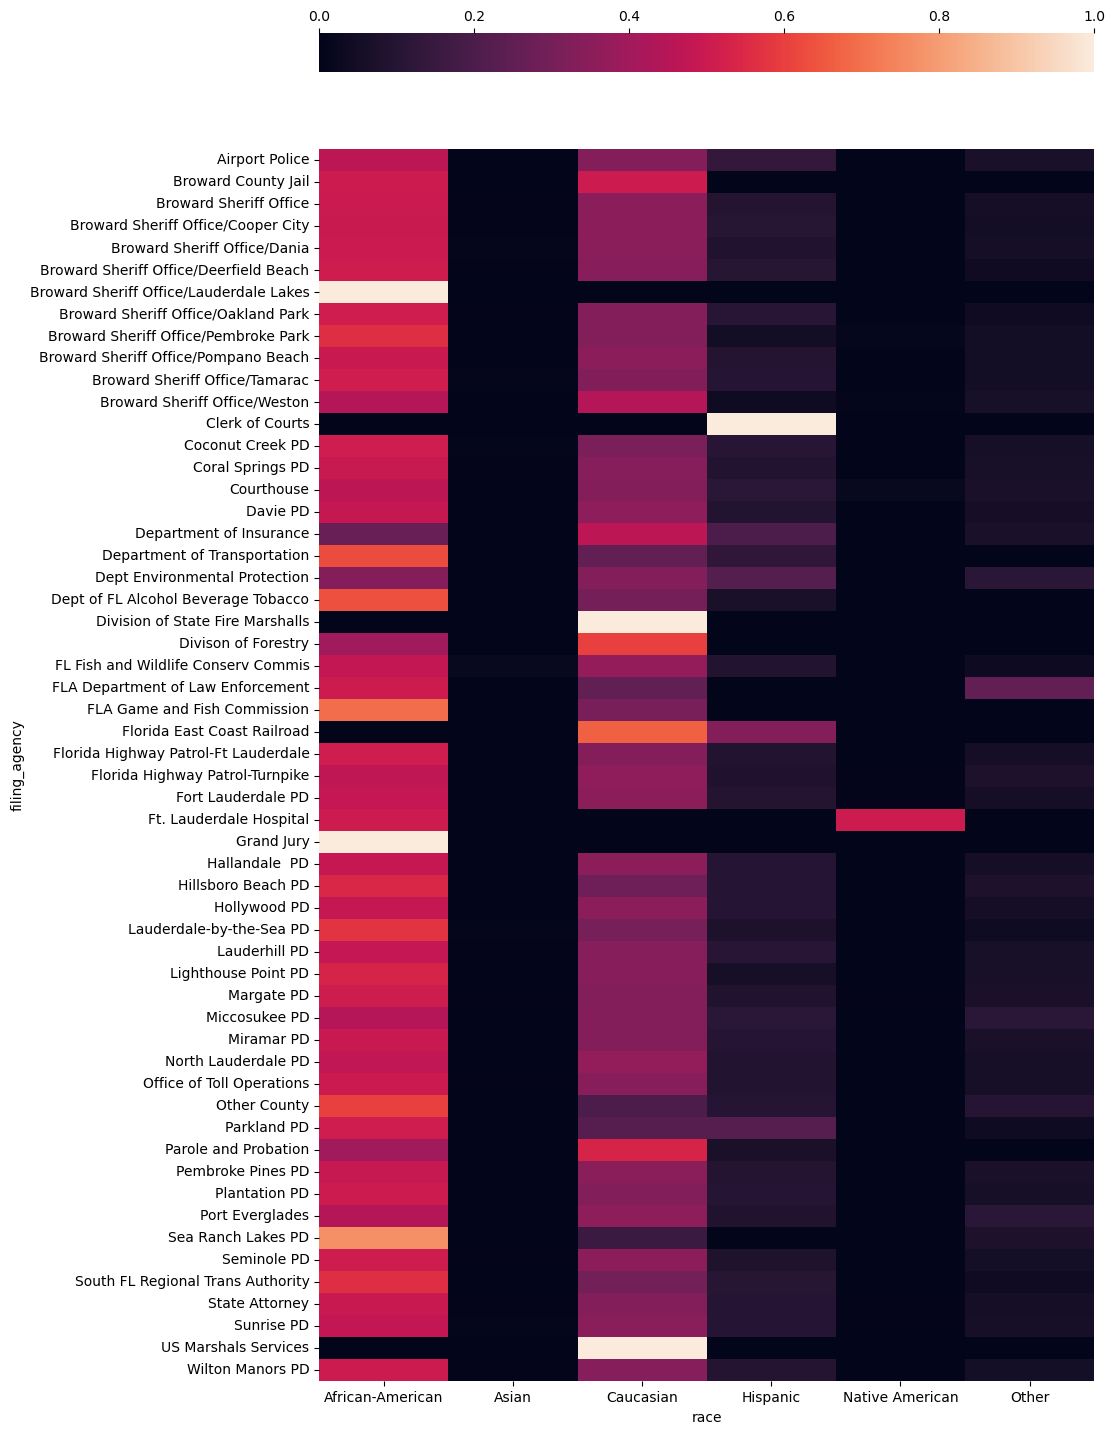

In [152]:
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt

cm = pd.crosstab(agency_race['filing_agency'], agency_race['race'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
fig, ax = plt.subplots(figsize=(10, 20))
cm = cm.div(cm.sum(axis=1), axis=0)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

By normalising column-wise, we're looking at distribution of locations for each race. So we can see that Broward Sheriff Office seems to cover a large population centre with most of the groups represented there but slightly more of the Asian community is found there than in other places. Ft Lauderdale PD also seems to have a large population catch but interacts with a larger percentage of the Native American population than any of the other offices. 

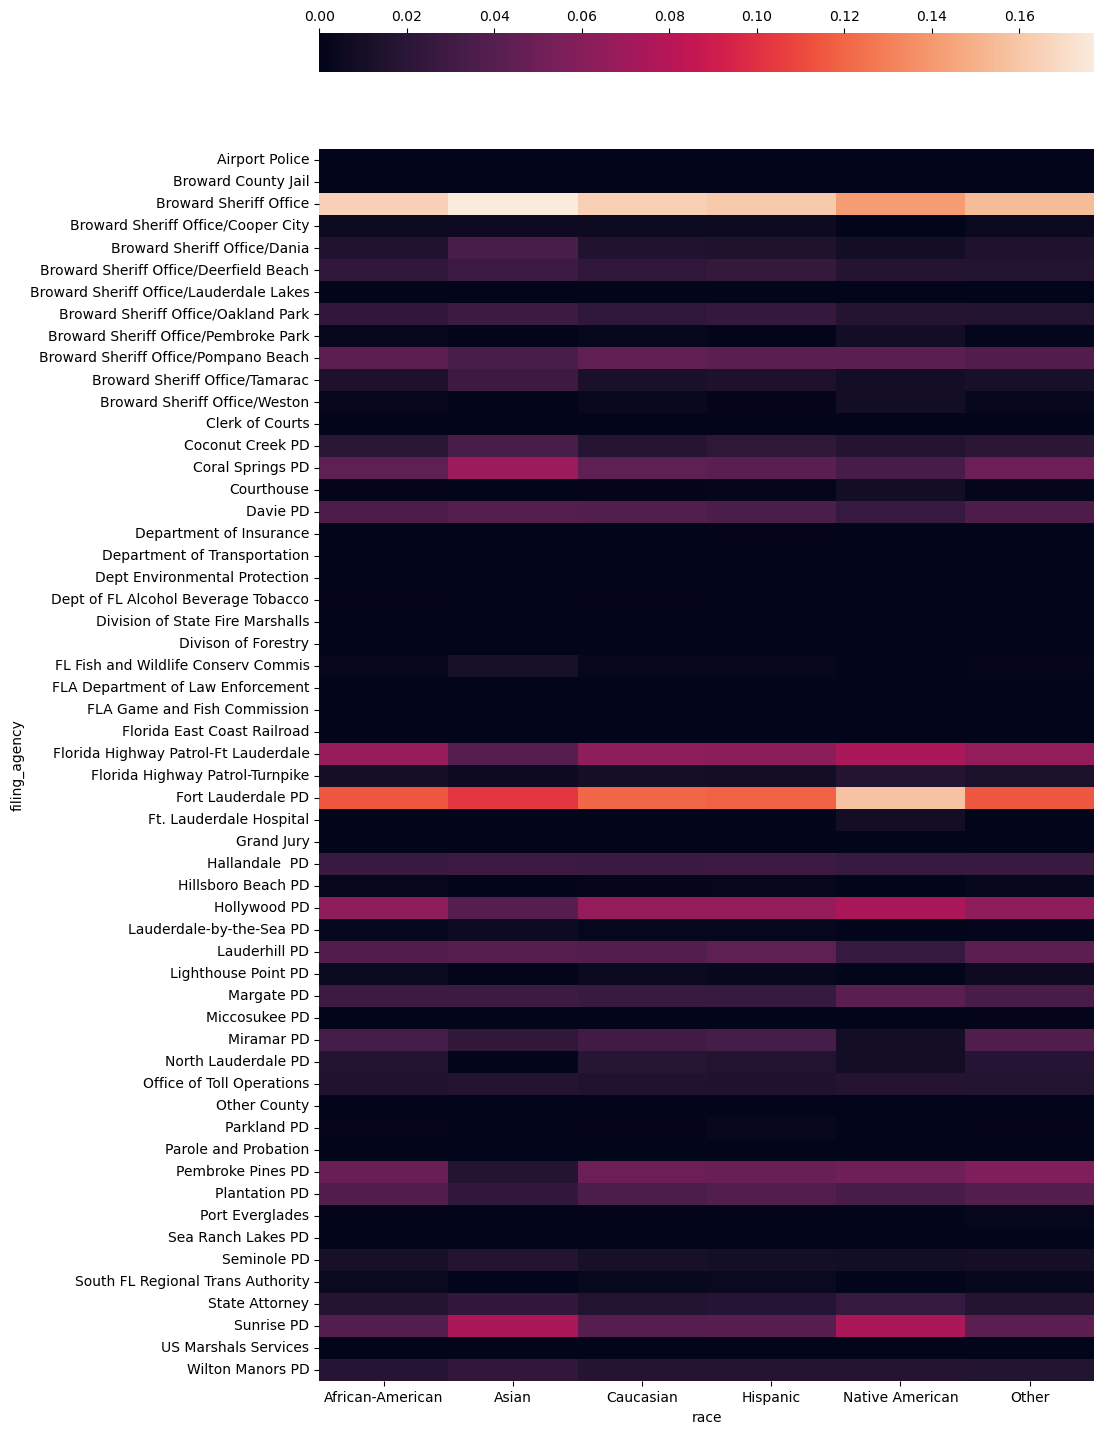

In [ ]:
cm = pd.crosstab(agency_race['filing_agency'], agency_race['race'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
cm = cm.div(cm.sum(axis=0), axis=1)
fig, ax = plt.subplots(figsize=(10, 20))
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

We can look at the similar breakdown of charge vs race. By normalising across rows we can see that almost on every charge type except CT (Contempt of Court), F5 (Sex Battery Deft 18+/Vict 11-  or Armed Sexual Battery), or X (None or Reckless Driving), has a higher percentage of Arican American suspects. 

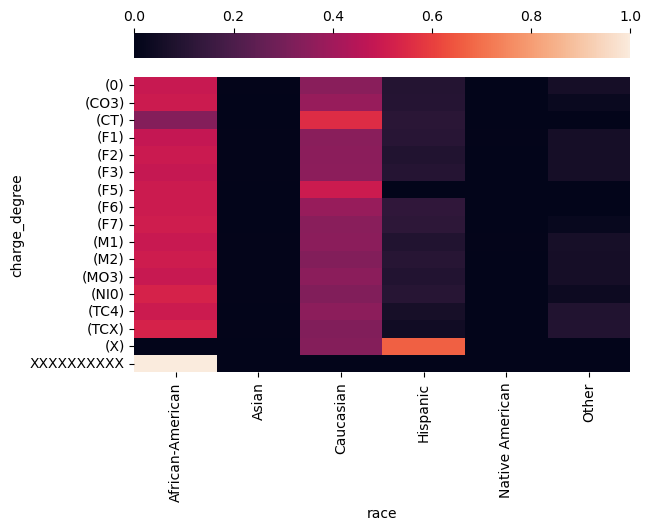

In [ ]:
cm = pd.crosstab(charge_race['charge_degree'], agency_race['race'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
cm = cm.div(cm.sum(axis=1), axis=0)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

By normalising across the columns we can see what charges each race is more likely to incur. 

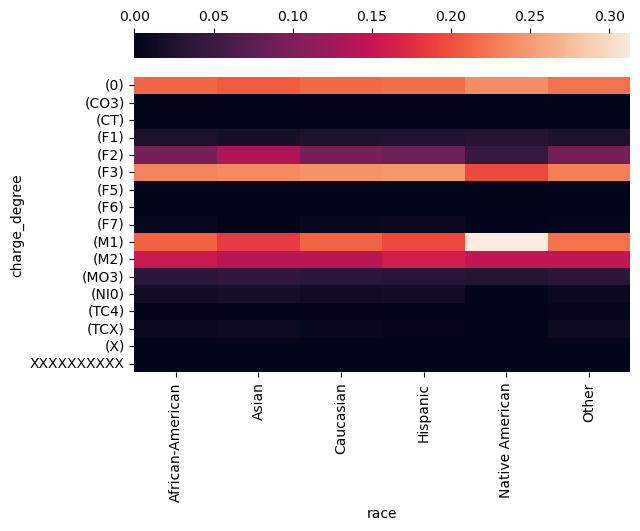

In [ ]:
cm = pd.crosstab(charge_race['charge_degree'], agency_race['race'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
cm = cm.div(cm.sum(axis=0), axis=1)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

One interesting thing would be to check if there's a correlation between the offence date and when someone was charged with the offence, but that's not possible with this data because these columns seem to be the same

False


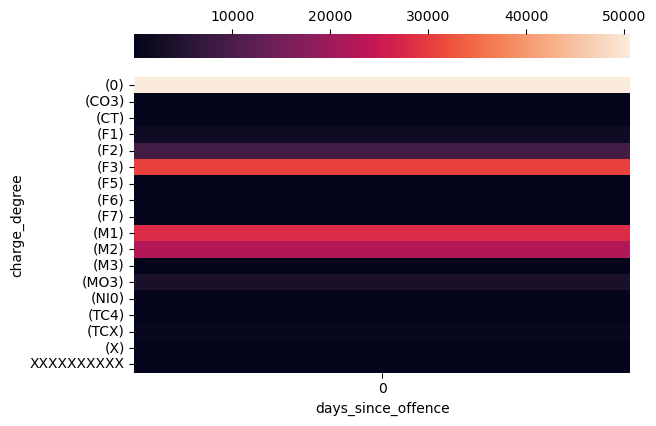

In [ ]:

df = pd.read_sql_query("SELECT * FROM charge", con)
df['date_charge_filed'] = pd.to_datetime(df['date_charge_filed'])
df['offense_date'] = pd.to_datetime(df['offense_date'])
print(any(df['date_charge_filed'] != df['offense_date']))
df['days_since_offence'] = (df['date_charge_filed']-df['offense_date']).dt.days
cm = pd.crosstab(df['charge_degree'], df['days_since_offence'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
#cm = cm.div(cm.sum(axis=0), axis=1)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

By normalising across the rows we can see what that men are more likely to commit most crimes other than CT - contempt of court, F5 sexual battery, and F6 murder in the first degree 

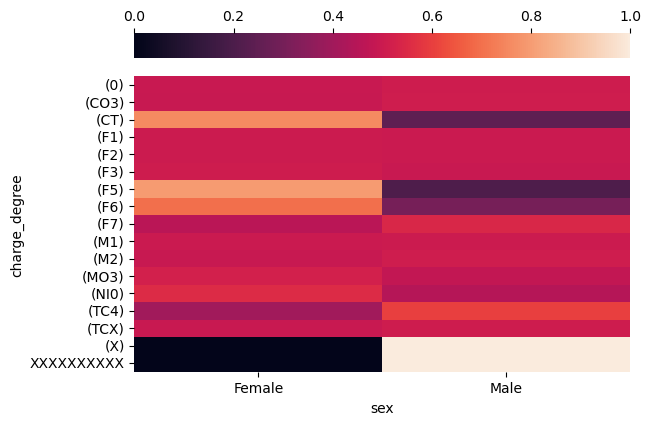

In [ ]:


cm = pd.crosstab(charge_race['charge_degree'], agency_race['sex'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
cm = cm.div(cm.sum(axis=0), axis=1)
cm = cm.div(cm.sum(axis=1), axis=0)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

By normalising columnwise we get the distribution of genders by location then by normalising rowise we see which locations arrest higher percentage of suspects of a particular gender. 

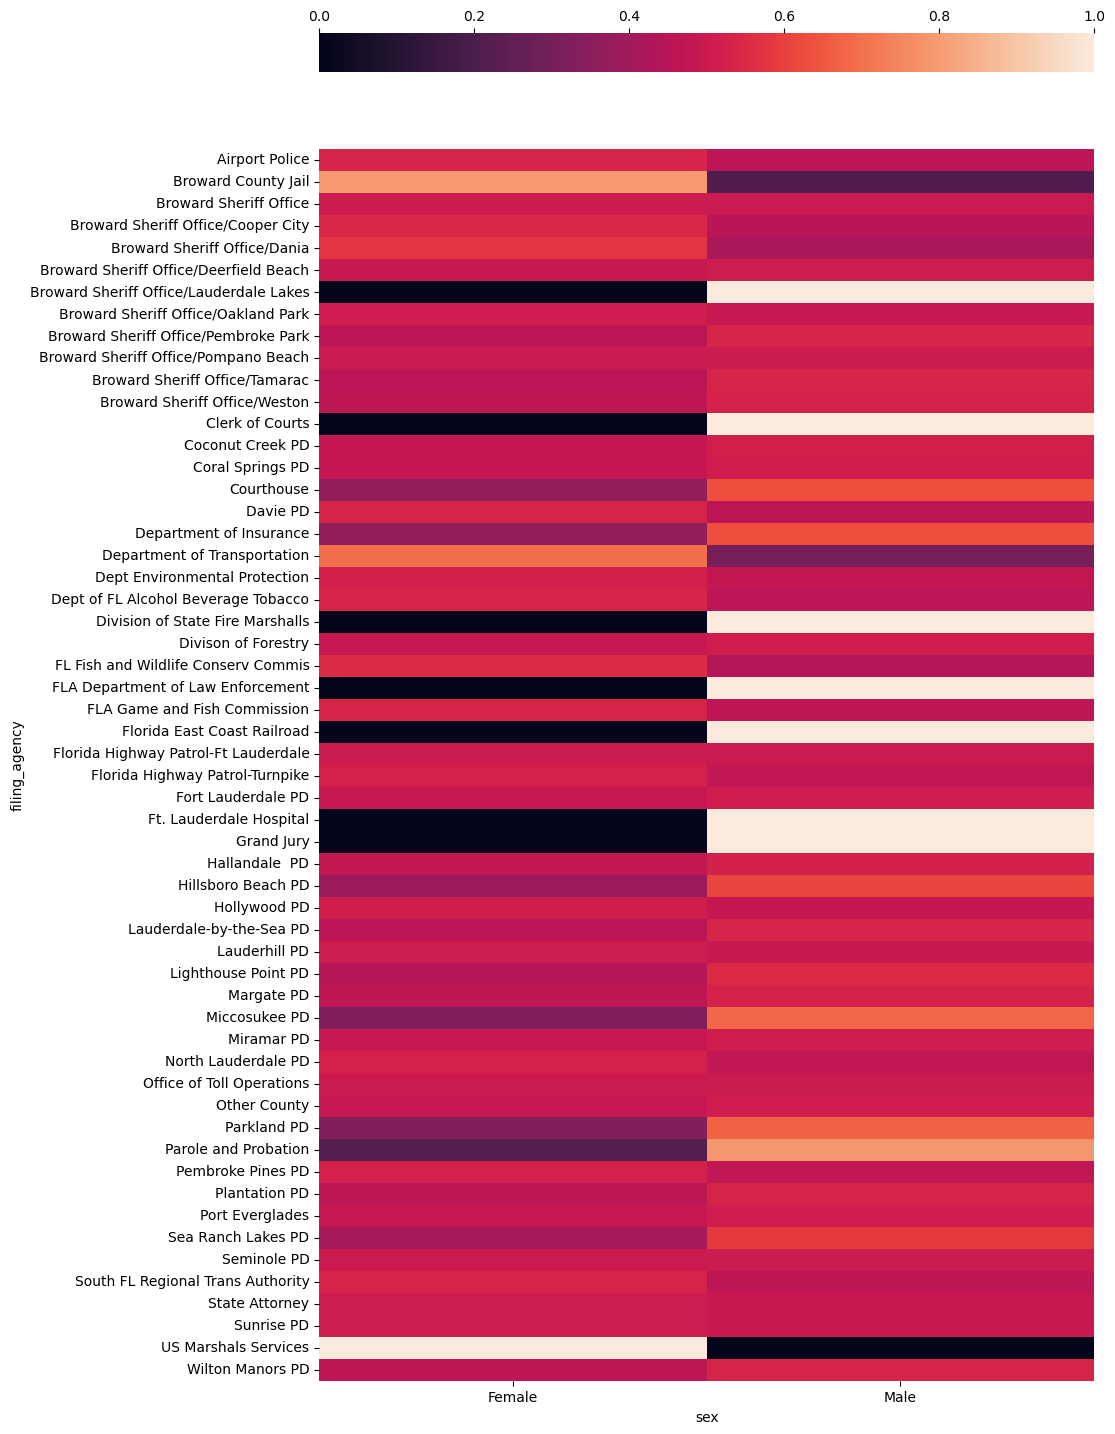

In [157]:


cm = pd.crosstab(agency_race['filing_agency'], agency_race['sex'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
fig, ax = plt.subplots(figsize=(10, 20))
cm = cm.div(cm.sum(axis=0), axis=1)
cm = cm.div(cm.sum(axis=1), axis=0)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

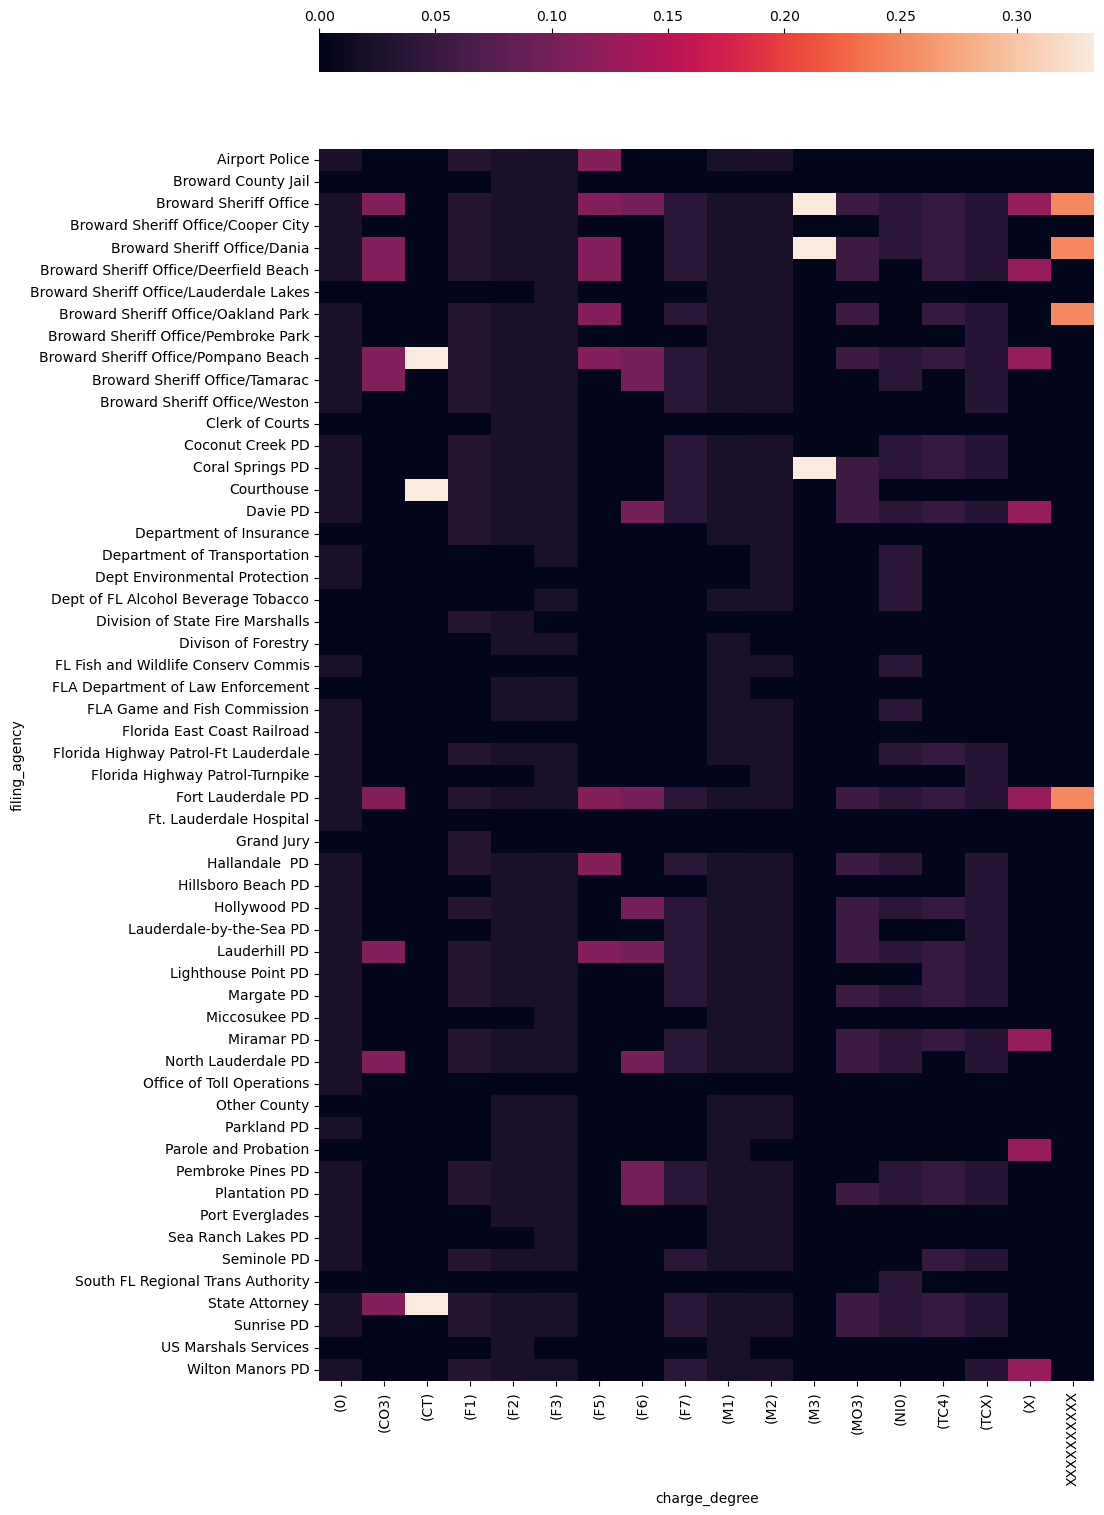

In [153]:

cm = pd.crosstab(charge_agency['filing_agency'], charge_agency['charge_degree'])
#cm = cm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
fig, ax = plt.subplots(figsize=(10, 20))
cm = cm.div(cm.sum(), axis=1)
#cm = cm.div(cm.sum(axis=1), axis=0)
sn.heatmap(cm,cbar_kws={'location': 'top'})
plt.show()

In [144]:
df = pd.read_parquet('joined_data/compas_v2_all_2y-label.pqt')

for c in df.columns:
    if c.startswith('word') or c.startswith('past'):
        df = df.drop(columns=[c])
profile = ProfileReport(df, title=f"Profiling Report Processed Data 2 year label",  minimal=False)
profile.to_file(f"data_profiles/processed-2y.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


In [138]:
charges = pd.read_sql_query("SELECT * FROM charge", con)
print('Mureder counts')
charges['charge'].str.contains('Murder').value_counts()
print('Sexual assault')
charges['charge'].str.contains('Sex').value_counts()
charges['charge'][charges['charge'].str.contains('Sex', na=False)].unique()




Mureder counts
Sexual assault


array(['Sex Battery Deft 17-/Vict 11-', 'Sex Battery Deft 18+/Vict 11-',
       'Poss W/I/Promot Sex Perf Child', 'Fail to Reg as Sexual Offender',
       'Sexual Performance by a Child',
       'Oss W/I/Promote Sex Perform Child',
       'Promoting Sex Perform by Child',
       'Human Trafficking-Forced Sex Actvty',
       'Attempt Sexual Batt / Vict 12+', 'Armed Sexual Battery',
       'Sex Offender Fail Comply W/Law', 'Unlawful Sexual Activity',
       'Sexual Battery / Vict 12 Yrs +', 'Armed Sex Batt/vict 12 Yrs +',
       'Sexual Battery Victim 12 Yrs +', 'Sex Batt Faml/Cust Vict 12-17Y',
       'Sexual Battery Victim Coerced', 'Sex Offender Fail Comply W/law',
       'Sex Battery Vict Incapacitated', 'Fail Sex Offend Report Bylaw',
       'Attempted Sexual Battery', 'Sex Trafficking',
       'False Accuse LEO of Sex Batter', 'Sex Violator Residency Viol',
       'Sexual Battery Victim Helpless', 'Sex Offender Residence Prohib',
       'Use/Child in Sex Perform', 'Sexual Offen/Pre

[0.9811888466490065, 0.5, 0.25, 0.14971326642687, 0.022414062144202957, 0.0005023901818041921]


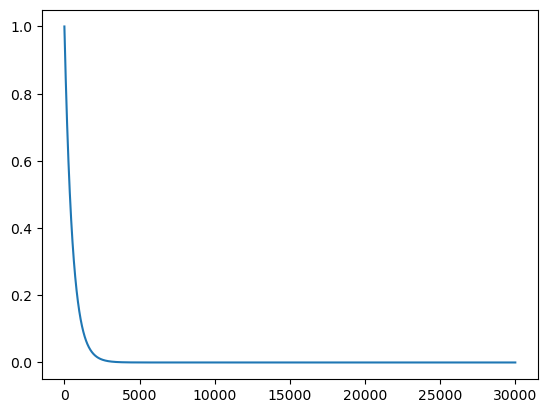

In [40]:
import matplotlib.pyplot as plt
import math
def fn(i):
    return (1/2)**(i/365)
x = [i for i in range(0, 30000, 10)]
y =[ fn(i) for i in x]
xt = [10, 365, 730, 1000, 2000, 4000]
print ([fn(i) for i in xt])
plt.plot(x, y)